# Amazon Fine Food Reviews - Sentiment Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon commercial website.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - Unique identifier for the product
3. UserId - Unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - Number of users who found the review helpful
6. HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not
7. Score - Rating between 1 and 5
8. Time - Timestamp for the review
9. Summary - Brief summary of the review
10. Text - Text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
#### Importing all the necessary libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# !pip install gensim==3.6.0  --> To install gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
    
from tqdm import tqdm
import os

# [1]. Reading Data

In [4]:
# To check the location of the file
os.getcwd()

'd:\\Sanket\\AI\\data-science\\Data Analysis'

In [3]:
# Using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

# filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3

# Here for TSNE Visualization we have taken 5k data points, you can also change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)  will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Giving reviews with Score > 3 as a positive rating, and reviews with Score < 3 as a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

# Changing reviews with Score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
# Display some attributes having count greater than 1.
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
# Displaying a particular UserId.
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
# Sum of all counts
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


##### Observation
The Duplicate entries have same product but different variations like -

1. ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)
2. ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

They all have different flavors and sizes/weights. So what happened was the user (Geeta Krishnan) gave a review for one product i.e for one flavor and size. 

Since all the products are Loacker Quadratini cookies, the manufacturer used this review for other flavors and sizes also and thats why there are multiple duplicate entires. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
# Sorting data according to ProductId in ascending order

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
# Deduplication of entries

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [12]:
# Checking to see how much % of data still remains

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

Here 0.28% of data was duplicate and removed, since we are doing this for 5k datapoints. The % of duplicate data will increase as there is increase in datapoints.

Removing duplicates is one type of cleaning of data. There are possibly other forms as well.

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions.

Since, Helpfulness Numerator is people who found review Helpul and clicked on YES. Helpfulness Denominator is people who found the review Helpul or not and clicked on either Yes or NO. This definitely says that the HelpfulnessDenominator >= HelpfulnessNumerator.

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
# Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

# How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

# Here N is 4986 ---> Used in Bag of Words.

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# Printing some random reviews - Review 0, Review 1000, Review 1500, and Review 4900 and separating them all with "=".

sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900) 
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [18]:
# Remove urls from text
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [19]:
# Removing all tags from text
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [20]:
# Expanding English language contractions
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [22]:
# remove words with numbers
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [23]:
# remove special characters
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [24]:
# We are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# We are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above steps 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3781.90it/s]


In [26]:
# Review 1500
preprocessed_reviews[1500] 

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [27]:
# Just to check
print(preprocessed_reviews[:2])

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product']


In [28]:
# Just to check
#print(preprocessed_reviews.shape)

P = np.array([preprocessed_reviews])
P.shape

(1, 4986)

# [4] Featurization

## [4.1] BAG OF WORDS

The Final dataframe after Data Cleaning and Text Preprocessing, is now in (preprocessed_reviews).

In this dataframe we have a column named Text which actually has the Text of all the Reviews
Here N = 4986, which was found after data cleaning. 

Now we convert all these reviews to their corresponding vectors using Bag of Words (BoW)

In [30]:
# BoW

count_vect = CountVectorizer() # Initializing the count vector
count_vect.fit(preprocessed_reviews)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [31]:
# Bi-gram, tri-gram and n-grams

# Imp - removing stop words like "not" should be avoided before building n-grams

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [33]:
# Here the final_tf_idf is the sparse matrix as mentioned above
features = tf_idf_vect.get_feature_names()
len(features)

3144

In [34]:
# We can see both Unigrams and Bigrams of some features here.
features[2000:2010] 

['pan',
 'pancake',
 'pancake mix',
 'pancake waffle',
 'pancakes',
 'pancakes waffles',
 'panda',
 'pantry',
 'paper',
 'part']

In [35]:
# If we want to get the vector of review 3 then
print(final_tf_idf[3,:].toarray()[0])

# Some values in the middle would be 1 or 2

[0. 0. 0. ... 0. 0. 0.]


In [36]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# So final_tf_idf[1,:] is a vector 1 corresponding to review 1, and converting to numpy array and getting the Top 25 features
top_tfidf = top_tfidf_feats(final_tf_idf[1:].toarray()[0],features,25)

In [37]:
top_tfidf

,feature,tfidf
0,ca not,0.443629
1,not beat,0.430058
2,ca,0.428025
3,beat,0.401487
4,great product,0.357997
5,used,0.254795
6,product,0.192976
7,great,0.172428
8,not,0.117442
9,fruit,0.000000


## [4.4] Word2Vec

In [38]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [39]:
want_to_train_w2v = True

if want_to_train_w2v:
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

[('excellent', 0.9928176403045654), ('snack', 0.9927079081535339), ('alternative', 0.9924212694168091), ('looking', 0.9924132823944092), ('regular', 0.9919516444206238), ('care', 0.9915378093719482), ('wonderful', 0.9915175437927246), ('dieting', 0.9914727807044983), ('healthy', 0.9912952780723572), ('overall', 0.9912427663803101)]
[('gourmet', 0.9995160698890686), ('otherwise', 0.9995144605636597), ('perhaps', 0.999456524848938), ('salmon', 0.9994558095932007), ('yes', 0.9994485974311829), ('easily', 0.9994406700134277), ('middle', 0.9994370341300964), ('gain', 0.9994312524795532), ('type', 0.9994233250617981), ('de', 0.9994213581085205)]


In [40]:
# Getting the vocabulary/dictionary of all the Word2Vec words.
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


In [59]:
w2v_model.wv.most_similar('tasty')

[('light', 0.9993431568145752),
 ('flavored', 0.999046802520752),
 ('plain', 0.9988080859184265),
 ('texture', 0.9988005757331848),
 ('honey', 0.9985902905464172),
 ('flavorful', 0.9985671043395996),
 ('hint', 0.99848473072052),
 ('artificial', 0.9984752535820007),
 ('mild', 0.9984258413314819),
 ('ginger', 0.998404324054718)]

## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [42]:
# Average Word2Vec
# Computing average word2vec for each review.
sent_vectors = [];                                # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance):               # for each review/sentence
    sent_vec = np.zeros(50)                       # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0;                                 # num of words with a valid vector in the sentence/review
    for word in sent:                             # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1492.12it/s]

4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [43]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names()
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; 
row=0; 
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:19<00:00, 250.67it/s]


## [5] Applying TSNE

 We are going to plot 4 TSNE plots with each of these feature set
    <ol>
        <li>Review text, preprocessed one converted into vectors using (BOW)</li>
        <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
        <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    </ol>    

## [5.1] Applying TNSE on Text BOW vectors

Note: TSNE accepts only dense matrixes.

In [1]:
# TSNE for 4000 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Here out of 4986 only 808 are negative reviews.
data_4000 = final_counts[0:4000:].todense()
labels_4000 = final["Score"][0:4000]

# Configuring the parameteres
model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500)
tsne_data = model.fit_transform(data_4000)

# Creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of TSNE
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4k reviews with perplexity = 20 and n_iter = 500')
plt.show()

NameError: name 'final_counts' is not defined

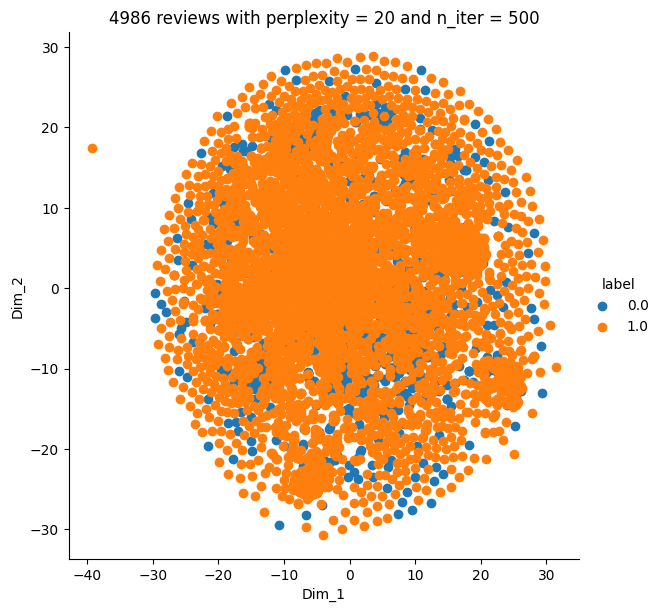

In [49]:
# TSNE for 4986 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Here out of 4986 only 808 something are negative reviews
data_2000 = final_counts[0:4986:].todense()
labels_2000 = final["Score"][0:4986]

model = TSNE(n_components=2, random_state=0,perplexity = 20,n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4986 reviews with perplexity = 20 and n_iter = 500')
plt.show()

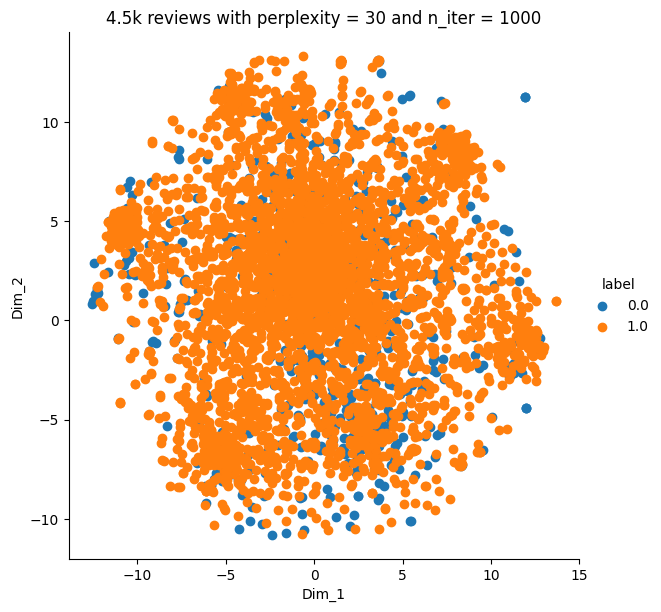

In [50]:
# Checking with different perplexity values and n_iterations, also add Titles and labels correctly

# TSNE for 4.5k reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
# But here out of 4986 only 800 something are negative reviews
data_2000 = final_counts[0:4500:].todense()
labels_2000 = final["Score"][0:4500]

model = TSNE(n_components=2, random_state=0,perplexity = 30,n_iter=1000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity = 30 and n_iter = 1000')
plt.show()

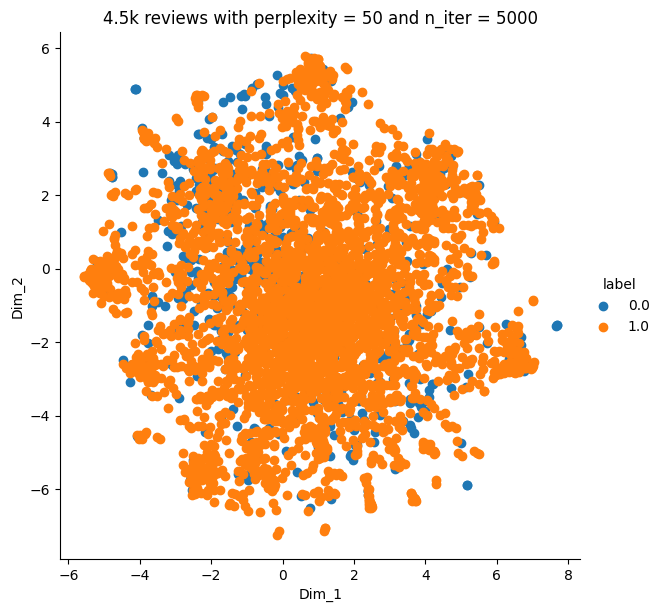

In [55]:
# Check with different perplexity values and n_iterations, also add Titles and labels correctly

# TSNE for 4.5k reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
# But here out of 4986 only 800 something are negative reviews
data_2000 = final_counts[0:4500:].todense()
labels_2000 = final["Score"][0:4500]

model = TSNE(n_components=2, random_state=0,perplexity = 50,n_iter=5000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
colors = {0:'red', 1:'blue'}

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity = 50 and n_iter = 5000')
plt.show()

In [60]:
# How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

1    4178
0     808
Name: Score, dtype: int64

While getting equal values of positive and negative reviews there was one error which was related to preprocessed_reviews or Cleaned_text rest of the things were fine, this error was a Type error - Dataframe is not callable, to check how the Tsne is for equal number of positive and negative reviews check in the below link --->

https://www.kaggle.com/code/premvardhan/amazon-fine-food-review-tsne-visualization/notebook#[7.2.2]-Bag-of-Words-(BoW)

Will check  how the error can be fixed later on.

## [5.2] Applying TNSE on Text TF-IDF vectors

In [ ]:
final_tf_idf

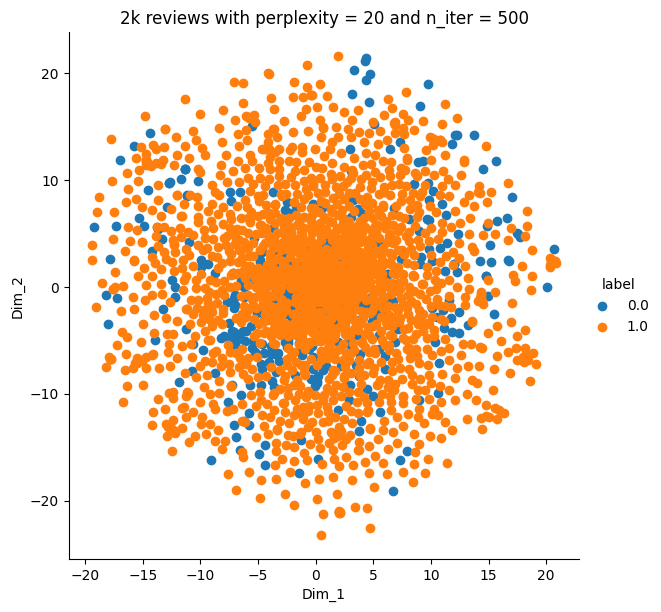

In [97]:
# TSNE for 2000 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 2000 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = final_tf_idf[0:2000:].todense() # Converting  sparse matrix to dense.
labels_2000 = final["Score"][0:2000]

model = TSNE(n_components=2, random_state=0, perplexity = 20, n_iter=500,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('2k reviews with perplexity = 20 and n_iter = 500')
plt.show()

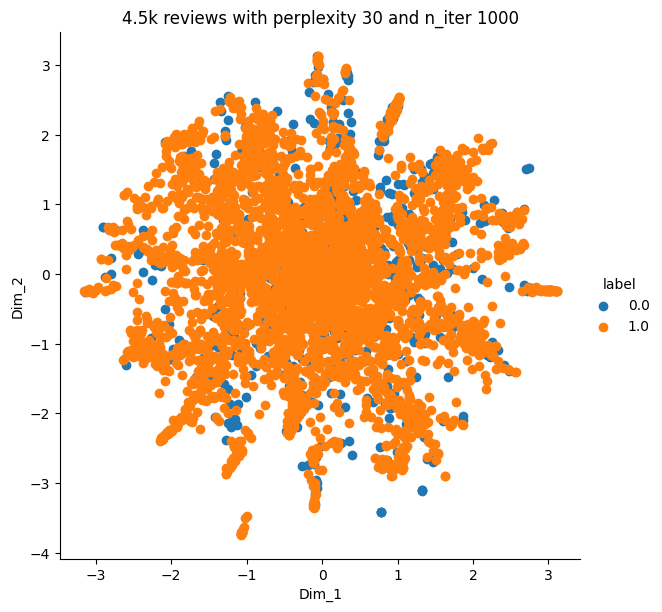

In [98]:
# TSNE for 4500 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 4500 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = final_tf_idf[0:4500:].todense() # Converting  sparse matrix to dense.
labels_2000 = final["Score"][0:4500]

model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity 30 and n_iter 1000')
plt.show()

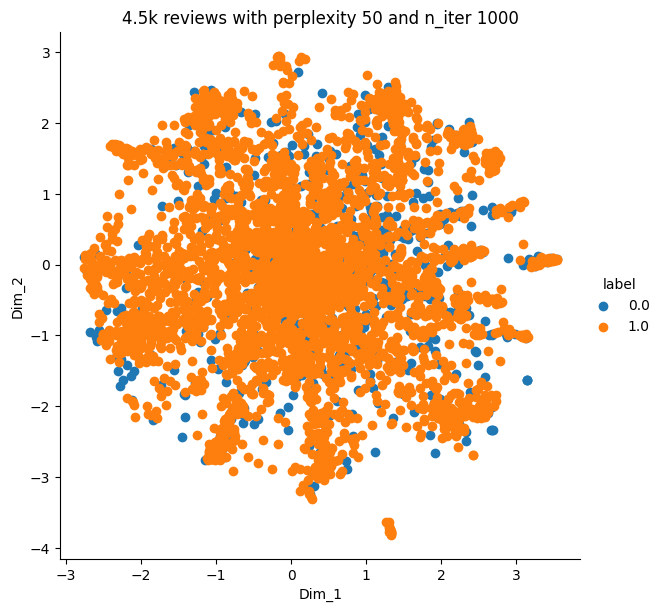

In [104]:
# TSNE for 4500 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 4500 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = final_tf_idf[0:4500:].todense() # Converting  sparse matrix to dense.
labels_2000 = final["Score"][0:4500]

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000,)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity 50 and n_iter 1000')
plt.show()

## [5.3] Applying TNSE on Text Avg W2V vectors

In [65]:
sent_vectors

[array([-0.38182898, -0.34718274, -0.4460047 ,  0.35502072,  0.45278948,
        -0.39390501,  0.28228337,  0.30975194, -0.02617184, -0.28444709,
        -0.20920619,  0.29929058, -0.00681497, -0.12700726, -0.06539801,
         0.24967374, -0.20794707, -0.41021452, -0.58759713, -0.4252206 ,
         0.03489084, -0.55698298, -0.02518542, -0.28217487, -0.24471099,
        -0.19287031, -0.08258439, -0.09269888,  0.59218913, -0.53966436,
        -0.19628815, -0.41734957,  0.10282397,  0.09761479, -0.0594598 ,
         0.58513556, -0.73372075,  0.14825302, -0.04139546, -0.48015545,
        -0.07980028,  0.07458172,  0.01972409,  0.24973363, -0.49901786,
         0.04703013, -0.70695261, -0.29895699, -0.06083752,  0.03116713]),
 array([-0.40737794, -0.39198162, -0.47192304,  0.37406648,  0.51909236,
        -0.44238358,  0.30485541,  0.37159567, -0.01808653, -0.29266971,
        -0.23162133,  0.37570563, -0.00552772, -0.13576009, -0.0860508 ,
         0.29701364, -0.2213859 , -0.46844445, -0

(4500, 50)


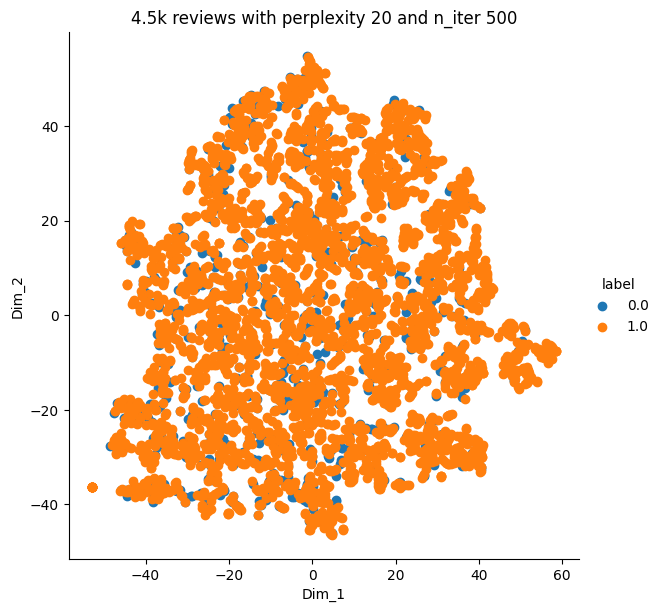

In [62]:
# TSNE for 4500 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 4500 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = sent_vectors[0:4500]
labels_2000 = final["Score"][0:4500]

# Error was appearing - AttributeError: 'list' object has no attribute 'shape'
data_2000 = np.array(data_2000) 
print(data_2000.shape)

model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=500)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity 20 and n_iter 500')
plt.show()

(4500, 50)


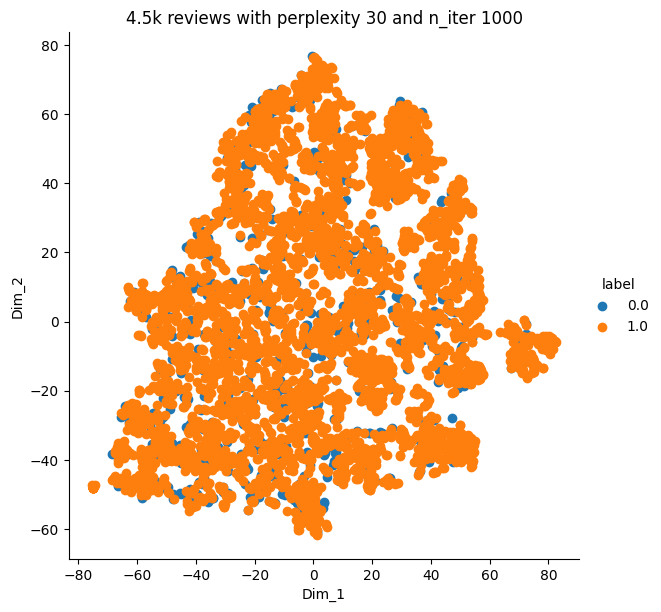

In [63]:
# TSNE for 4500 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 4500 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = sent_vectors[0:4500]
labels_2000 = final["Score"][0:4500]

# Error was appearing - AttributeError: 'list' object has no attribute 'shape'
data_2000 = np.array(data_2000) 
print(data_2000.shape)

model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity 30 and n_iter 1000')
plt.show()

(4500, 50)


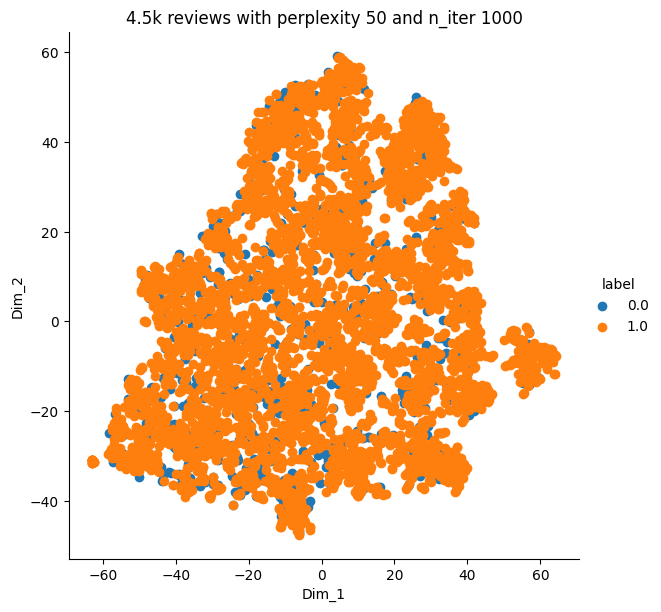

In [64]:
# TSNE for 4500 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 4500 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = sent_vectors[0:4500]
labels_2000 = final["Score"][0:4500]

# Error was appearing - AttributeError: 'list' object has no attribute 'shape'
data_2000 = np.array(data_2000) 
print(data_2000.shape)

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity 50 and n_iter 1000')
plt.show()

## [5.3] Applying TNSE on Text TFIDF W2v vectors

In [66]:
tfidf_sent_vectors

[array([-0.3379247 , -0.30169238, -0.39224565,  0.32051483,  0.39869746,
        -0.34087431,  0.24375864,  0.27122232, -0.02251583, -0.25012169,
        -0.18656962,  0.25326302, -0.02250183, -0.11337112, -0.0578411 ,
         0.21519277, -0.18720941, -0.36368878, -0.52644641, -0.3831906 ,
         0.02697444, -0.48677448, -0.0332027 , -0.24774836, -0.22384285,
        -0.16558139, -0.06068296, -0.06931606,  0.52145661, -0.48593781,
        -0.17388034, -0.37817163,  0.0937253 ,  0.08497686, -0.06065908,
         0.50823417, -0.65188376,  0.12924568, -0.03016564, -0.42667353,
        -0.07443346,  0.07212536,  0.00421443,  0.22193659, -0.44190951,
         0.04631956, -0.61545434, -0.26736051, -0.04800784,  0.03110547]),
 array([-0.37627575, -0.34448957, -0.43621203,  0.34294251,  0.45669019,
        -0.39414279,  0.282343  ,  0.32527378, -0.01997049, -0.27206729,
        -0.20641409,  0.31571868, -0.00394531, -0.12579767, -0.0679407 ,
         0.26217466, -0.20613416, -0.41969284, -0

(4500, 50)


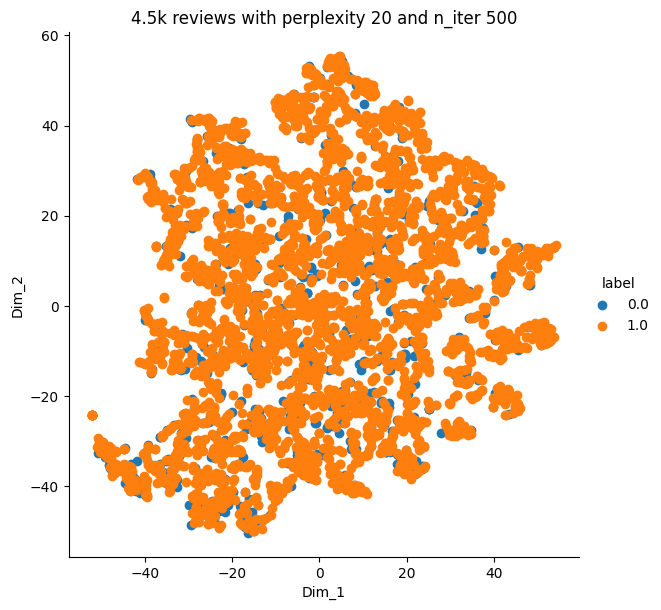

In [69]:
# TSNE for 4500 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 4500 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = tfidf_sent_vectors[0:4500]
labels_2000 = final["Score"][0:4500]

# Error was appearing - AttributeError: 'list' object has no attribute 'shape'
data_2000 = np.array(data_2000) 
print(data_2000.shape)

model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=500)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity 20 and n_iter 500')
plt.show()

(4500, 50)


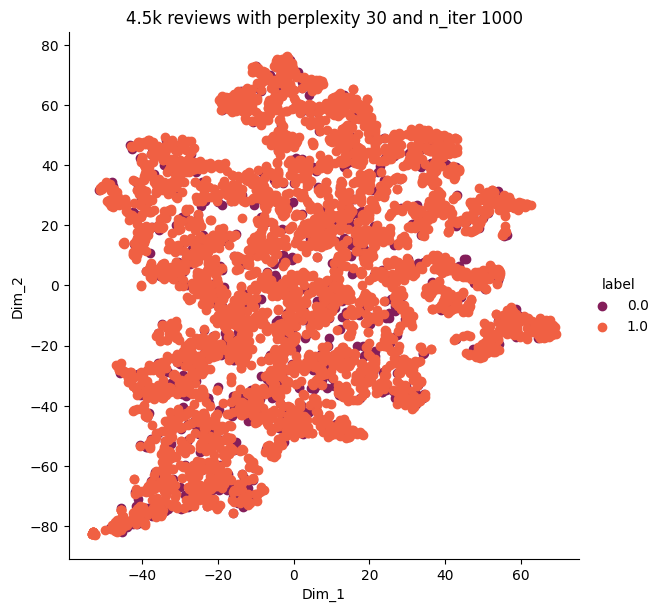

In [84]:
# TSNE for 4500 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 4500 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = tfidf_sent_vectors[0:4500]
labels_2000 = final["Score"][0:4500]

# Error was appearing - AttributeError: 'list' object has no attribute 'shape'
data_2000 = np.array(data_2000) 
print(data_2000.shape)

model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, palette="rocket", hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity 30 and n_iter 1000')
plt.show()

# palette="" is used to change the color of labels e.g-palette="blend:#7AB,#EDA"
# https://seaborn.pydata.org/tutorial/color_palettes.html

(4500, 50)


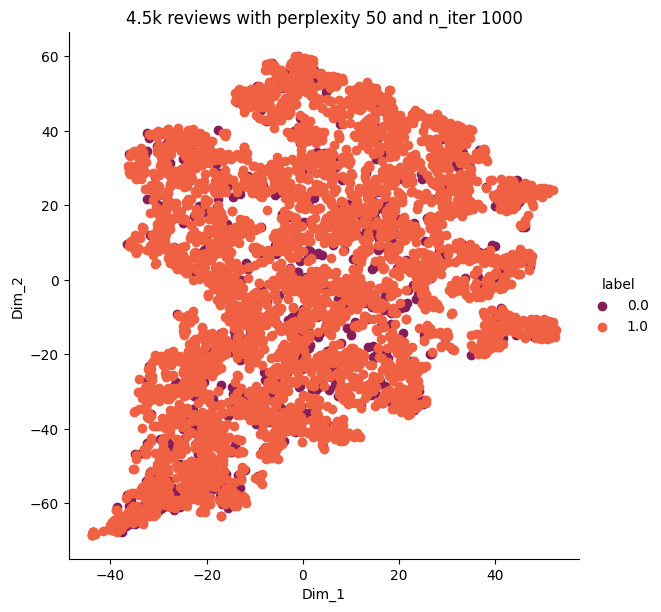

In [85]:
# TSNE for 4500 reviews

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 4500 points as TSNE takes a lot of time for 364K points
# Just a reminder that here out of 4986 only 800 something are negative reviews
data_2000 = tfidf_sent_vectors[0:4500]
labels_2000 = final["Score"][0:4500]

# Error was appearing - AttributeError: 'list' object has no attribute 'shape'
data_2000 = np.array(data_2000) 
print(data_2000.shape)

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, palette="rocket", hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('4.5k reviews with perplexity 50 and n_iter 1000')
plt.show()

# palette="" is used to change the color of labels e.g-palette="blend:#7AB,#EDA"
# https://seaborn.pydata.org/tutorial/color_palettes.html

<b>Observation</b> - After seeing all the plots we can say that both the +ve and -ve reviews are not well seperated the values are overlapping each other and hence it is unreadable.

<b>Conclusions</b> :-

1. Here none of the TSNE representations present above separates both +ve and -ve reviews.
2. Since TSNE is used for dimensionally reduction and well suited for visualizing high dimensional data, we are using TSNE here here just for visualization.
3. From this visualizations the takeaway is that whatever model or classifier we use, it will not perform well, because the data is not linearly separable. But if we do some feature engineering on this data and apply logistic regression then it will work fairly well, we can also try with kernel svm.